<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/dev/Tony/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1: Do the preparation for transfer learning**

In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from pathlib import Path
import imghdr

# sklearn utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# others
import os, gc, time
import tqdm, re, json
import glob 
from skimage import io 

# set up random seed
import random
seed = 24

# customize printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 200)
     

# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/NewDrive')
     




Mounted at /content/NewDrive


In [ ]:
TRAIN_DATA_PATH = '/content/NewDrive/MyDrive/MMAI894TeamProject/train'
VALID_DATA_PATH = '/content/NewDrive/MyDrive/MMAI894TeamProject/valid'

CLASS_NAMES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASS_NAMES)

Define utility functions


*   training history plot
*   confusion matrix


In [ ]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

In [ ]:
def make_confusion_matrix(cf, group_names=None,categories='auto', count=True,percent=False,cbar=True, 
                          xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
     

In [ ]:
def error_analysis(model, test_data):
  plt.figure(figsize=(18,12))
  for image_batch,label_batch in test_data.take(1):
      predictions = model.predict(image_batch)
      predictions = np.argmax(predictions, axis=-1)
      for i in range(0,len(predictions) if len(predictions)<12 else 12):
          plt.subplot(3,4,i+1)
          plt.imshow(image_batch[i].numpy().astype("uint32"))
          true_class = test_data.class_names[np.argmax(label_batch[i])]
          predict_class = test_data.class_names[predictions[i]]
          title = f"""True: {true_class}\n Predict: {predict_class}"""
          plt.title(title, color='g' if true_class==predict_class else 'r')
          plt.axis("off")
     

# **2.Delete the useless images**

In [ ]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images


In [ ]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images
     

In [ ]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [ ]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)
     

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
-------------------- check training set image quality. --------------------
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/EB_(976).jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(7).jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(6).jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(975).jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(98).jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(976).jpg is not an image
/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/607

In [ ]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs
-------------------- check training set image quality. --------------------


Bacterial_spot         :  29%|████████████                              | 808/2826 [00:01<00:02, 995.37file/s]

/content/NewDrive/MyDrive/MMAI894TeamProject/train/Bacterial_spot/bacterialspotontomatoXant.JPG


Early_blight           :  42%|████████████████▊                       | 1029/2455 [00:01<00:01, 1200.06file/s]

/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg


healthy                :  24%|██████████                                | 730/3051 [00:02<00:02, 814.92file/s]

/content/NewDrive/MyDrive/MMAI894TeamProject/train/healthy/edible-tomato-leaves.jpg


healthy                :  96%|██████████████████████████████████████▍ | 2932/3051 [00:06<00:00, 1124.91file/s]

/content/NewDrive/MyDrive/MMAI894TeamProject/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png


powdery_mildew         : 100%|█████████████████████████████████████████| 1004/1004 [00:01<00:00, 938.43file/s]


-------------------- check test and validation set image quality. --------------------


Leaf_Mold              : 100%|██████████████████████████████████████████| 739/739 [00:00<00:00, 1590.98file/s]


/content/NewDrive/MyDrive/MMAI894TeamProject/valid/Leaf_Mold/BM_(9).jpg


healthy                :  77%|████████████████████████████████▎         | 621/806 [00:00<00:00, 1236.18file/s]

/content/NewDrive/MyDrive/MMAI894TeamProject/valid/healthy/2013-08-20-05.jpg
/content/NewDrive/MyDrive/MMAI894TeamProject/valid/healthy/HL_(336).png


powdery_mildew         : 100%|██████████████████████████████████████████| 252/252 [00:00<00:00, 1576.06file/s]


In [ ]:
# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.48 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 340950.63file/s]


-------------------- check test and validation set image quality. --------------------


healthy                : 100%|███████████████████████████████████████████| 806/806 [00:01<00:00, 525.86file/s]


defective image file:  /content/NewDrive/MyDrive/MMAI894TeamProject/valid/healthy/HL_(336).png


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 200296.50file/s]


In [ ]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

{'/content/NewDrive/MyDrive/MMAI894TeamProject/train/Bacterial_spot/bacterialspotontomatoXant.JPG',
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg'),
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/EB_(976).jpg'),
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg'),
 '/content/NewDrive/MyDrive/MMAI894TeamProject/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg',
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/607-155-1.jpg'),
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(6).jpg'),
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(7).jpg'),
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(975).jpg'),
 PosixPath('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Leaf_Mold/BM_(976).jpg'),
 Posi

Move 25 images with bad quality.


In [ ]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25835
6677


# **3.Load the data and do train test valid spilt**

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 
BATCH_SIZE = 32
LABEL_MODE = 'categorical'  # labels: one-hot encoded, a float32 tensor of shape (batch_size, num_classes). loss: categorical_crossentropy
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5

In [ ]:
# training set - expect 25,851 (25,837) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25835 files belonging to 11 classes.


In [ ]:
# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        directory=VALID_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed,
        validation_split = VALID_TEST_RATIO, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [ ]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'
     

# **4.Data Argumentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
      # layers.RandomHeight(0.2),
      # layers.RandomWidth(0.2),
    ], name = 'data_augmentation'
)
     

# **5.Data preprocessing**

In [ ]:
preprocessing = keras.Sequential(
    [
      # layers.Resizing(IMG_HEIGHT, IMG_WIDTH), 
      layers.Rescaling((1./255), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # some pre-trained model requires [-1, 1] like MobileNet, I would pass `scale=1./127.5, offset=-1`      
    ], name='preprocessing'
)

# **6.Transfer learning with VGG**

In [ ]:
#Load the VGG model
model_VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Add some other layers 
VGG_model = tf.keras.Sequential([
                preprocessing,
                model_VGG,

                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dropout(rate=0.5),
                tf.keras.layers.Dense(NUM_CLASSES),
                tf.keras.layers.Softmax()])

VGG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                        

In [ ]:
#Compile the model
VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
       metrics=["accuracy"])

Early Stopping

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=5, 
    verbose=1
)

Model Training

In [ ]:
EPOCHS = 50

history = VGG_model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = EPOCHS,
    callbacks = [early_stopping]
)


Epoch 1/50
808/808 [==============================] - 638s 748ms/step - loss: 1.1891 - accuracy: 0.5848 - val_loss: 0.4162 - val_accuracy: 0.8541
Epoch 2/50
808/808 [==============================] - 51s 63ms/step - loss: 0.4473 - accuracy: 0.8495 - val_loss: 0.3203 - val_accuracy: 0.8919
Epoch 3/50
808/808 [==============================] - 51s 63ms/step - loss: 0.3082 - accuracy: 0.8970 - val_loss: 0.2399 - val_accuracy: 0.9134
Epoch 4/50
808/808 [==============================] - 51s 63ms/step - loss: 0.2295 - accuracy: 0.9240 - val_loss: 0.2385 - val_accuracy: 0.9251
Epoch 5/50
808/808 [==============================] - 51s 63ms/step - loss: 0.2045 - accuracy: 0.9324 - val_loss: 0.2073 - val_accuracy: 0.9284
Epoch 6/50
808/808 [==============================] - 51s 63ms/step - loss: 0.1602 - accuracy: 0.9465 - val_loss: 0.2023 - val_accuracy: 0.9383
Epoch 7/50
808/808 [==============================] - 51s 63ms/step - loss: 0.1369 - accuracy: 0.9544 - val_loss: 0.1907 - val_accurac

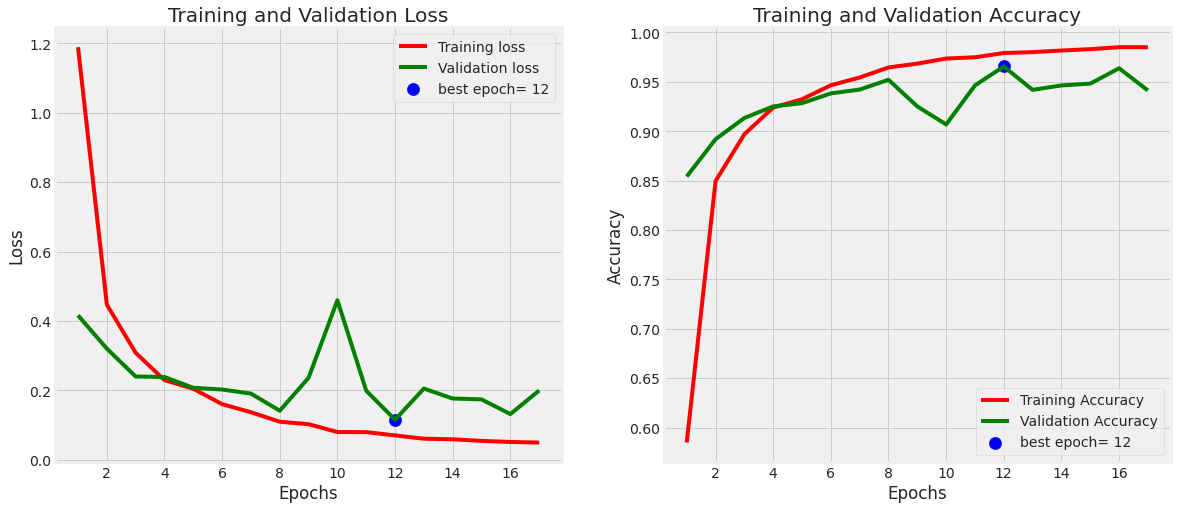

In [ ]:
plot_training(history)

In [ ]:
test_loss, test_accuracy = VGG_model.evaluate(test_ds)

105/105 [==============================] - 69s 654ms/step - loss: 0.1257 - accuracy: 0.9691


In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(VGG_model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 153ms/step


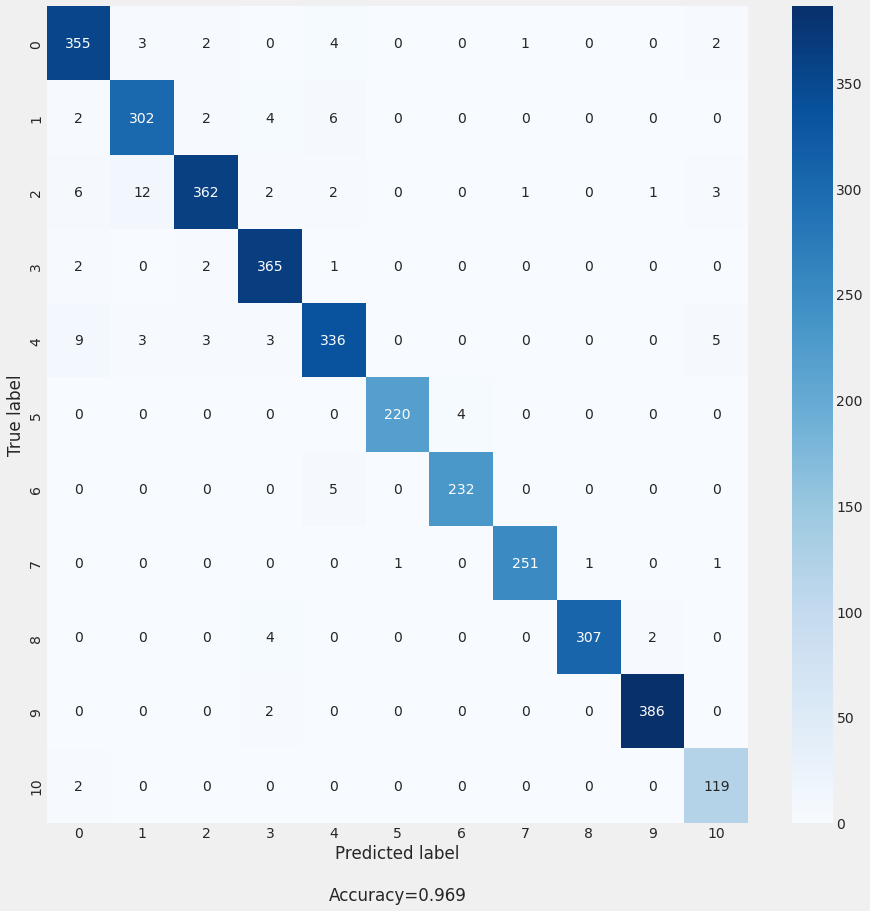

In [ ]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, test_ds.class_names,figsize=(14,14))